In [ ]:
!pip install pybaseball
!pip install matplotlib seaborn

In [ ]:
from pybaseball import cache
cache.enable()

Gathering Player Data


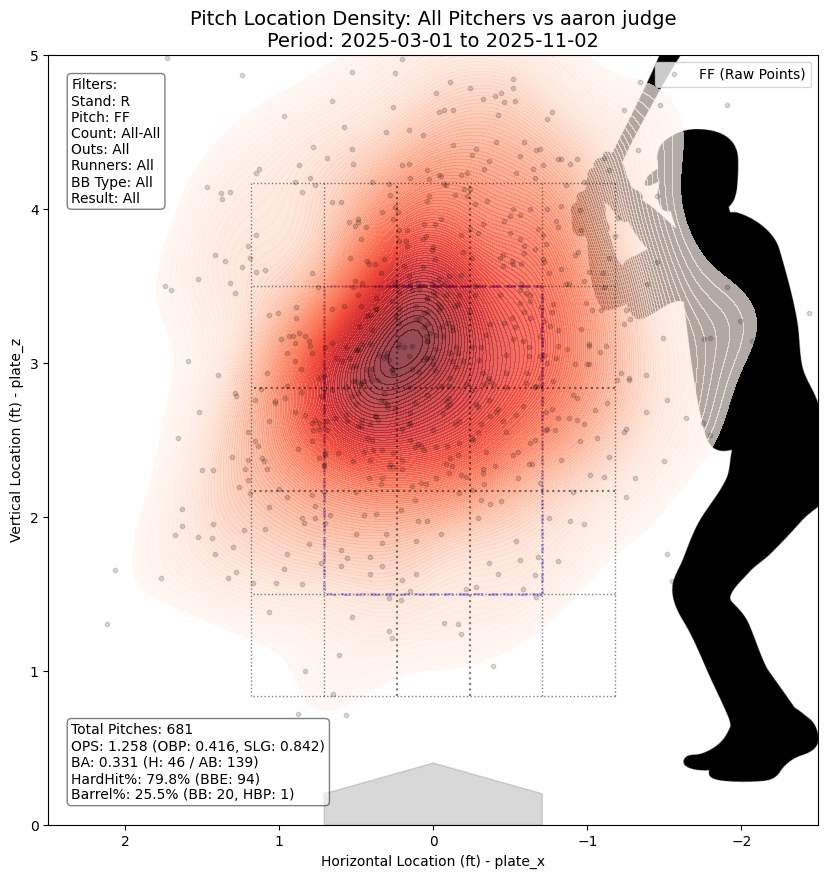

In [8]:
import pybaseball
import pandas as pd
from pybaseball import statcast, statcast_pitcher, statcast_batter, playerid_lookup
import time 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.image as mpimg 

pd.set_option('display.max_columns', None)

# --- 1. 設定 ---
# 選手名と、グラフ化したい条件を指定します

# --- 1a. 選手名 ---
PITCHER_FIRST_NAME = ''
PITCHER_LAST_NAME = ''

BATTER_FIRST_NAME = 'aaron'
BATTER_LAST_NAME = 'judge'

# 取得する期間
START_DATE = '2025-03-01'
END_DATE = '2025-11-02' 

# (空欄 '' で「すべて」のフィルター)
PITCH_CODE = 'FF'     # 例: 'FF', 'SL', 'CU', 'CH', 'SI', 'FC', 'KC', 'FS'
BATTER_STAND = 'R'  # 'R' または 'L'
TARGET_BALLS = ''   # '0', '1', '2', '3'
TARGET_STRIKES = '' # '0', '1', '2'
TARGET_BB_TYPE = '' # 'ground_ball', 'fly_ball', 'line_drive', 'popup'
TARGET_RESULT = ''  # 'strikeout', 'walk', 'single', 'home_run', 'woba_zero' (wOBAが0のイベント)
TARGET_OUTS = ''    # '0', '1', '2'
TARGET_RUNNERS = '' # 'EMPTY', 'RISP', 'ON BASE (NOT RISP)'

# --- 1c. 試合タイプ (データ取得フィルター) ---
# R: Regular Season, S: Spring Training, E: Exhibition
# A: All-Star Game
# ★ 'P' を指定するとポストシーズン (F, D, L, W) が自動的に含まれます。
# 例: ['R', 'P'] -> レギュラーシーズンとポストシーズン両方
GAME_TYPES_TO_INCLUDE = ['R'] # デフォルトはレギュラーシーズンのみ

# --- 1d. バッター画像 (オプション) ---
BATTER_IMAGE_FILE_R = 'batterR.png' 
BATTER_IMAGE_EXTENT_R = [-4.5, 1.0, 0, 6.0] 
BATTER_IMAGE_FILE_L = 'batterL.png'
BATTER_IMAGE_EXTENT_L = [-1.0, 4.5, 0, 6.0] 

# --- 1e. 分析タイプ ---
# 'density'   (ヒートマップ)
# 'woba'      (wOBAマップ)
# 'ba'        (打率マップ)
# 'ops'       (OPSマップ)
# 'hard_hit'  (ハードヒット率マップ)
# 'barrel'    (バレル率マップ)
ANALYSIS_TYPE = 'density' 

# --- 1f. グラフの色の範囲 ---
WOBA_VMIN, WOBA_VMAX = 0.200, 0.500
BA_VMIN, BA_VMAX = 0.100, 0.400
OPS_VMIN, OPS_VMAX = 0.500, 1.200
HARD_HIT_VMIN, HARD_HIT_VMAX = 0.0, 0.500 
BARREL_VMIN, BARREL_VMAX = 0.0, 0.300



def calculate_batting_stats(df):
    if 'events' not in df.columns:
        print("警告: 'events' カラムがないため、打撃指標の計算をスキップします。")
        df['is_hit'] = 0
        df['slugging_base'] = 0
        df['is_at_bat'] = 0
        df['is_walk'] = 0
        df['is_hbp'] = 0
        df['is_sac_fly'] = 0
        df['is_pa_event'] = 0
        return df
        
    events = df['events'].fillna('nan').str.lower()
    
    hits_map = {'single': 1, 'double': 1, 'triple': 1, 'home_run': 1}
    df['is_hit'] = events.map(hits_map).fillna(0).astype(int)
    
    tb_map = {'single': 1, 'double': 2, 'triple': 3, 'home_run': 4}
    df['slugging_base'] = events.map(tb_map).fillna(0).astype(int)
    
    # 打数 (AB) となるイベント
    ab_events = [
        'field_out', 'strikeout', 'grounded_into_double_play', 'force_out',
        'double_play', 'fielders_choice', 'field_error', 'sac_bunt_field_out',
        'strikeout_double_play', 'triple_play', 'fielders_choice_out',
        'sac_fly_double_play', 'other_out', 'bunt_groundout', 'bunt_field_out'
    ]
    is_ab_event = events.isin(ab_events)
    df['is_at_bat'] = ((df['is_hit'] == 1) | is_ab_event).astype(int)
    
    df['is_walk'] = (events.isin(['walk', 'intent_walk'])).astype(int) # 申告敬遠も含む
    df['is_hbp'] = (events == 'hit_by_pitch').astype(int)
    df['is_sac_fly'] = (events == 'sac_fly').astype(int)
    
    # 打席(PA)が完了したイベント
    df['is_pa_event'] = (df['is_at_bat'] == 1) | (df['is_walk'] == 1) | \
                        (df['is_hbp'] == 1) | (df['is_sac_fly'] == 1)
    
    return df

def calculate_advanced_metrics(df):
    if 'bb_type' in df.columns:
        df['is_batted_ball'] = df['bb_type'].notnull().astype(int)
    else:
        df['is_batted_ball'] = 0
    
    if 'launch_speed' in df.columns:
        df['is_hard_hit'] = (df['launch_speed'] >= 95.0).astype(int)
    else:
        df['is_hard_hit'] = 0 

    if 'launch_speed' in df.columns and 'launch_angle' in df.columns:
        ls = df['launch_speed'].fillna(0) 
        la = df['launch_angle'].fillna(0) 
        cond1 = (ls >= 98) & (ls < 100) & (la >= 26) & (la <= 30)
        cond2 = (ls >= 100) & (ls < 105) & (la >= 24) & (la <= 33)
        cond3 = (ls >= 105) & (ls < 110) & (la >= 22) & (la <= 36)
        cond4 = (ls >= 110) & (ls < 116) & (la >= 18) & (la <= 43)
        cond5 = (ls >= 116) & (la >= 8) & (la <= 50)
        df['is_barrel'] = np.where(cond1 | cond2 | cond3 | cond4 | cond5, 1, 0)
    else:
        print("警告: 'launch_speed'/'launch_angle' がないため、'is_barrel' は 0 に設定されます。")
        df['is_barrel'] = 0
    return df

def calculate_counts_and_runners(df):
    """ 1球ごとのカウントと走者状況を計算 (グラフ描画スクリプト基準) """
    # 走者カラム
    if 'on_1b' in df.columns and 'on_2b' in df.columns and 'on_3b' in df.columns:
        # statcast()はID(数値)かNaN、CSVは1/0かNaN
        df['on_1b_bool'] = (df['on_1b'].notnull() & (df['on_1b'] != 0)).astype(int)
        df['on_2b_bool'] = (df['on_2b'].notnull() & (df['on_2b'] != 0)).astype(int)
        df['on_3b_bool'] = (df['on_3b'].notnull() & (df['on_3b'] != 0)).astype(int)
    else:
        print("警告: 走者カラム ('on_1b', 'on_2b', 'on_3b') が見つかりません。")
        df['on_1b_bool'] = False
        df['on_2b_bool'] = False
        df['on_3b_bool'] = False
    
    df['is_risp'] = (df['on_2b_bool'] | df['on_3b_bool']).astype(bool)
    df['is_empty'] = (df['on_1b_bool'] == False) & (df['on_2b_bool'] == False) & (df['on_3b_bool'] == False)

    if 'outs_when_up' not in df.columns:
        print("警告: 'outs_when_up' カラムが見つかりません。")
        df['outs_when_up'] = -1 
    
    # カウント計算 (1球ごとのdescriptionから再計算)
    balls_list = []
    strikes_list = []
    desc_list = [] 
    events_list = [] 
    current_balls = 0
    current_strikes = 0
    strike_descs = ['called_strike', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked', 'missed_bunt']
    foul_descs = ['foul', 'foul_bunt']
    ball_descs = ['ball', 'pitchout']
    
    # 必要なカラムが揃っているか確認
    if 'events' not in df.columns or 'description' not in df.columns:
        print("警告: 'events'/'description' がないため、1球ごとのカウント再計算をスキップします。")
        df['balls'] = df['balls'].fillna(0).astype(int) if 'balls' in df.columns else 0
        df['strikes'] = df['strikes'].fillna(0).astype(int) if 'strikes' in df.columns else 0
        return df

    for index, row in df.iterrows():
        balls_list.append(current_balls)
        strikes_list.append(current_strikes)
        
        at_bat_over = False
        evt = str(row['events']).lower()
        events_list.append(evt)
        if evt != 'nan': 
            at_bat_over = True
            
        desc = str(row['description']).lower()
        desc_list.append(desc) 
        
        if desc in ball_descs: current_balls += 1
        elif desc in strike_descs: current_strikes += 1
        elif desc in foul_descs:
            if current_strikes < 2: current_strikes += 1
            
        if current_balls == 4 or current_strikes == 3: 
            at_bat_over = True
            
        if at_bat_over: 
            current_balls = 0
            current_strikes = 0
            
    df['balls'] = balls_list
    df['strikes'] = strikes_list
    df['description'] = desc_list # クリーンアップした値を上書き
    df['events'] = events_list     # クリーンアップした値を上書き
    
    return df

# --- 補助関数 (グラフ描画用) ---

def draw_strike_zone(ax): 
    plate_width_ft = 17 / 12 
    sz_left = -plate_width_ft / 2
    sz_right = plate_width_ft / 2
    sz_bottom = 1.5
    sz_top = 3.5
    zone = plt.Rectangle((sz_left, sz_bottom), width=(sz_right - sz_left), 
                         height=(sz_top - sz_bottom),
                         fill=False, edgecolor='blue', linewidth=2, linestyle='--')
    ax.add_patch(zone)
    home_plate = plt.Polygon([(sz_left, 0), (sz_right, 0), (sz_right, 0.2), 
                              (0, 0.4), (sz_left, 0.2)], color='gray', alpha=0.3)
    ax.add_patch(home_plate)
    
    # 9分割 + 外枠 (5x5) のグリッド線
    sz_width_3x3 = (sz_right - sz_left)
    sz_height_3x3 = (sz_top - sz_bottom)
    w = sz_width_3x3 / 3.0
    h = sz_height_3x3 / 3.0
    
    x_lines = [sz_left - w, sz_left, sz_left + w, sz_right - w, sz_right, sz_right + w]
    z_lines = [sz_bottom - h, sz_bottom, sz_bottom + h, sz_top - h, sz_top, sz_top + h]
    
    line_props = {'color': 'black', 'linestyle': ':', 'alpha': 0.5}
    
    # 縦線
    ax.plot([x_lines[1], x_lines[1]], [z_lines[0], z_lines[5]], **line_props, linewidth=1) # 外枠
    ax.plot([x_lines[2], x_lines[2]], [z_lines[0], z_lines[5]], **line_props, linewidth=1.5) # ゾーン内
    ax.plot([x_lines[3], x_lines[3]], [z_lines[0], z_lines[5]], **line_props, linewidth=1.5) # ゾーン内
    ax.plot([x_lines[4], x_lines[4]], [z_lines[0], z_lines[5]], **line_props, linewidth=1) # 外枠
    ax.plot([x_lines[0], x_lines[0]], [z_lines[0], z_lines[5]], **line_props, linewidth=1) # 枠外
    ax.plot([x_lines[5], x_lines[5]], [z_lines[0], z_lines[5]], **line_props, linewidth=1) # 枠外
    
    # 横線
    ax.plot([x_lines[0], x_lines[5]], [z_lines[1], z_lines[1]], **line_props, linewidth=1) # 外枠
    ax.plot([x_lines[0], x_lines[5]], [z_lines[2], z_lines[2]], **line_props, linewidth=1.5) # ゾーン内
    ax.plot([x_lines[0], x_lines[5]], [z_lines[3], z_lines[3]], **line_props, linewidth=1.5) # ゾーン内
    ax.plot([x_lines[0], x_lines[5]], [z_lines[4], z_lines[4]], **line_props, linewidth=1) # 外枠
    ax.plot([x_lines[0], x_lines[5]], [z_lines[0], z_lines[0]], **line_props, linewidth=1) # 枠外
    ax.plot([x_lines[0], x_lines[5]], [z_lines[5], z_lines[5]], **line_props, linewidth=1) # 枠外

def draw_batter_silhouette(ax, batter_stand): 
    use_ellipse = True 
    if batter_stand == 'R' and BATTER_IMAGE_FILE_R:
        try:
            img = mpimg.imread(BATTER_IMAGE_FILE_R)
            ax.imshow(img, extent=BATTER_IMAGE_EXTENT_R, aspect='auto', zorder=0)
            use_ellipse = False 
        except FileNotFoundError:
            print(f"警告: 右打者用画像 '{BATTER_IMAGE_FILE_R}' が見つかりません。")
        except Exception as e:
            print(f"警告: 右打者用画像の読み込みエラー: {e}")
    elif batter_stand == 'L' and BATTER_IMAGE_FILE_L:
        try:
            img = mpimg.imread(BATTER_IMAGE_FILE_L)
            ax.imshow(img, extent=BATTER_IMAGE_EXTENT_L, aspect='auto', zorder=0)
            use_ellipse = False 
        except FileNotFoundError:
            print(f"警告: 左打者用画像 '{BATTER_IMAGE_FILE_L}' が見つかりません。")
        except Exception as e:
            print(f"警告: 左打者用画像の読み込みエラー: {e}")
            
    if use_ellipse:
        if batter_stand == 'R': base_x = -2.5
        elif batter_stand == 'L': base_x = 2.5
        else: return 
        common_props = {'color': 'gray', 'alpha': 0.5, 'zorder': 0} 
        torso = patches.Ellipse((base_x, 3.0), 2.0, 6.0, **common_props)
        ax.add_patch(torso)

def get_summary_metrics(df_in):
    if df_in.empty:
        return {}, "データがありません"

    pa_denom = df_in['is_pa_event'].sum()
    at_bats = df_in['is_at_bat'].sum()
    hits = df_in['is_hit'].sum()
    walks = df_in['is_walk'].sum() # 'intent_walk' も含む (calculate_batting_stats で処理済)
    hbps = df_in['is_hbp'].sum()
    sac_fly = df_in['is_sac_fly'].sum()
    slugging_base = df_in['slugging_base'].sum()
    
    batted_balls = df_in['is_batted_ball'].sum()
    hard_hits = df_in['is_hard_hit'].sum()
    barrels = df_in['is_barrel'].sum()

    # OBP (出塁率)
    obp_denom = at_bats + walks + hbps + sac_fly
    obp = (hits + walks + hbps) / obp_denom if obp_denom > 0 else 0.0
    
    # SLG (長打率)
    slg = slugging_base / at_bats if at_bats > 0 else 0.0
    
    # OPS
    ops = obp + slg
    
    # BA (打率)
    ba = hits / at_bats if at_bats > 0 else 0.0

    # Hard Hit % (BBEあたり)
    hard_hit_rate = hard_hits / batted_balls if batted_balls > 0 else 0.0
    
    # Barrel % (BBEあたり)
    barrel_rate = barrels / batted_balls if batted_balls > 0 else 0.0
    
    metrics = {
        "PA": pa_denom,
        "AB": at_bats,
        "H": hits,
        "BB": walks,
        "HBP": hbps,
        "BBE": batted_balls,
        "HardHit": hard_hits,
        "Barrel": barrels,
        "BA": ba,
        "OBP": obp,
        "SLG": slg,
        "OPS": ops,
        "HardHit%": hard_hit_rate,
        "Barrel%": barrel_rate
    }
    
    # テキスト生成
    text = (
        f"OPS: {ops:.3f} (OBP: {obp:.3f}, SLG: {slg:.3f})\n"
        f"BA: {ba:.3f} (H: {hits} / AB: {at_bats})\n"
        f"HardHit%: {hard_hit_rate:.1%} (BBE: {batted_balls})\n"
        f"Barrel%: {barrel_rate:.1%} (BB: {walks}, HBP: {hbps})"
    )
    
    return metrics, text


# --- メイン実行ブロック ---
def main():
    
    # --- 2. 選手IDの検索 ---
    pitcher_id = None
    batter_id = None
    
    # (★★★ 修正点: 姓または名の *どちらか* が入力されていれば検索 ★★★)
    try:
        if PITCHER_FIRST_NAME or PITCHER_LAST_NAME:
            pitcher_list = playerid_lookup(PITCHER_LAST_NAME, PITCHER_FIRST_NAME)
            if pitcher_list.empty:
                raise SystemExit(f"エラー: 投手 '{PITCHER_FIRST_NAME} {PITCHER_LAST_NAME}' が見つかりません。")
            pitcher_id = pitcher_list.iloc[0]['key_mlbam']

        if BATTER_FIRST_NAME or BATTER_LAST_NAME:
            batter_list = playerid_lookup(BATTER_LAST_NAME, BATTER_FIRST_NAME)
            if batter_list.empty:
                raise SystemExit(f"エラー: 対戦打者 '{BATTER_FIRST_NAME} {BATTER_LAST_NAME}' が見つかりません。")
            batter_id = batter_list.iloc[0]['key_mlbam']

    except Exception as e:
        print(f"選手IDの検索中にエラー: {e}")
        raise SystemExit("処理を中断します。")
    # (★★★ 修正ここまで ★★★)

    # --- 3. Statcast データの取得 ---
    try:
        
        # 1. 投手だけが指定されている場合 (高速)
        if pitcher_id and not batter_id:
            raw_stats = statcast_pitcher(
                start_dt=START_DATE,
                end_dt=END_DATE,
                player_id=pitcher_id
            )

        # 2. 打者だけが指定されている場合 (高速)
        elif not pitcher_id and batter_id:
            raw_stats = statcast_batter(
                start_dt=START_DATE,
                end_dt=END_DATE,
                player_id=batter_id
            )

        # 3. 投手と打者の両方が指定されている場合 (対戦データ)
        elif pitcher_id and batter_id:
            raw_stats_pitcher = statcast_pitcher(
                start_dt=START_DATE,
                end_dt=END_DATE,
                player_id=pitcher_id
            )
            
            if 'batter' not in raw_stats_pitcher.columns:
                raise SystemExit(f"エラー: 取得データに 'batter' カラムがありません。対戦絞り込みできません。")
            
            raw_stats = raw_stats_pitcher[raw_stats_pitcher['batter'] == batter_id].copy()
            if raw_stats.empty:
                print(f"警告: {PITCHER_FIRST_NAME} {PITCHER_LAST_NAME} vs {BATTER_FIRST_NAME} {BATTER_LAST_NAME} の対戦データが見つかりませんでした。")

        # 4. 両方とも空欄の場合 (月単位で分割取得)
        else:
            date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')
            
            start_dates = [START_DATE] + [d.strftime('%Y-%m-%d') for d in date_ranges]
            end_dates = [d.strftime('%Y-%m-%d') for d in date_ranges - pd.Timedelta(days=1)] + [END_DATE]
            
            if len(start_dates) > 1 and start_dates[0] == start_dates[1]:
                start_dates = start_dates[1:]
                end_dates = end_dates[1:]
            
            all_data_chunks = [] 
            
            for start, end in zip(start_dates, end_dates):
                if pd.to_datetime(start) > pd.to_datetime(end):
                    continue
                try:
                    monthly_data = statcast(start_dt=start, end_dt=end)
                    if not monthly_data.empty:
                        all_data_chunks.append(monthly_data)
                    time.sleep(5) # サーバー負荷軽減のため、待機時間を5秒に延長
                except Exception as e:
                    print(f"警告: {start} から {end} のデータ取得中にエラー: {e}")
            
            if not all_data_chunks:
                raw_stats = pd.DataFrame() 
            else:
                raw_stats = pd.concat(all_data_chunks, ignore_index=True)

        # 4b. 試合タイプ (game_type) で絞り込み (移植)
        if not raw_stats.empty and GAME_TYPES_TO_INCLUDE:
            if 'game_type' in raw_stats.columns:
                
                # 'P' (Postseason) が含まれていたら、F, D, L, W に展開する
                game_types_processed = []
                if 'P' in GAME_TYPES_TO_INCLUDE:
                    postseason_types = ['F', 'D', 'L', 'W']
                    game_types_processed.extend([t for t in GAME_TYPES_TO_INCLUDE if t != 'P'])
                    game_types_processed.extend([t for t in postseason_types if t not in game_types_processed])
                else:
                    game_types_processed = GAME_TYPES_TO_INCLUDE.copy()

                raw_stats = raw_stats[raw_stats['game_type'].isin(game_types_processed)].copy()
                
                if raw_stats.empty:
                    print(f"警告: {game_types_processed} の試合タイプに一致するデータが見つかりませんでした。")
            else:
                print("警告: 取得データに 'game_type' カラムがありません。絞り込みをスキップします。")
        

        if raw_stats.empty:
            print(f"データが空です。指定した条件での記録はありません。")
            return # グラフ描画に進まず終了

    except Exception as e:
        print(f"Statcastデータの取得中にエラーが発生しました: {e}")
        return

    # --- 4. データの処理 (ソート、計算) ---
    
    # 4a. 時系列ソート (カウント計算の前に必須)
    if 'game_date' in raw_stats.columns and 'at_bat_number' in raw_stats.columns and 'pitch_number' in raw_stats.columns:
         # game_pk もキーに追加して、ダブルヘッダーなどに対応
         sort_keys = ['game_date', 'game_pk', 'at_bat_number', 'pitch_number']
         missing_keys = [k for k in sort_keys if k not in raw_stats.columns]
         if missing_keys:
             print(f"警告: ソートキー {missing_keys} が不足しています。'game_date' のみでソートします。")
             sort_keys = ['game_date']
         
         df = raw_stats.sort_values(by=sort_keys).reset_index(drop=True)
         
    elif 'game_date' in raw_stats.columns:
         df = raw_stats.sort_values(by=['game_date']).reset_index(drop=True)
    else:
         print("警告: 'game_date' がないため、時系列ソートが不完全です。")
         df = raw_stats.reset_index(drop=True) # とりあえずインデックスだけ振り直す

    # 4b. カウント、走者、打撃スタッツ、高度な指標の計算
    df = calculate_counts_and_runners(df)
    df = calculate_batting_stats(df)
    df = calculate_advanced_metrics(df) 

    # --- 5. 段階的フィルター ---
    df_filtered = df.copy()
    if PITCH_CODE:
        # pitch_type (Statcast) と pitch_name (CSV) の両方に対応
        pitch_col = 'pitch_type' if 'pitch_type' in df_filtered.columns else 'pitch_name'
        if pitch_col in df_filtered.columns:
            df_filtered = df_filtered[df_filtered[pitch_col] == PITCH_CODE]
        else:
            print(f"警告: 投球タイプカラム ({pitch_col}) が見つかりません。")
            
    if BATTER_STAND:
        df_filtered = df_filtered[df_filtered['stand'] == BATTER_STAND]
        
    if TARGET_BALLS != '':
        try:
            df_filtered = df_filtered[df_filtered['balls'] == int(TARGET_BALLS)]
        except ValueError: print(f"警告: TARGET_BALLS '{TARGET_BALLS}' は無効。")
        
    if TARGET_STRIKES != '':
        try:
            df_filtered = df_filtered[df_filtered['strikes'] == int(TARGET_STRIKES)]
        except ValueError: print(f"警告: TARGET_STRIKES '{TARGET_STRIKES}' は無効。")
        
    if TARGET_OUTS != '':
        try:
            df_filtered = df_filtered[df_filtered['outs_when_up'] == int(TARGET_OUTS)]
        except ValueError: print(f"警告: TARGET_OUTS '{TARGET_OUTS}' は無効。")
    
    runner_setting = str(TARGET_RUNNERS).upper() 
    if runner_setting == 'EMPTY':
        df_filtered = df_filtered[df_filtered['is_empty'] == True]
    elif runner_setting == 'RISP':
        df_filtered = df_filtered[df_filtered['is_risp'] == True]
    elif runner_setting == 'ON BASE (NOT RISP)': 
        df_filtered = df_filtered[
            (df_filtered['is_empty'] == False) & (df_filtered['is_risp'] == False)
        ]
        
    if TARGET_BB_TYPE:
        df_filtered = df_filtered[df_filtered['bb_type'] == TARGET_BB_TYPE]
        
    if TARGET_RESULT: 
        result_str_lower = TARGET_RESULT.lower()
        if result_str_lower == 'woba_zero':
            df_filtered = df_filtered[df_filtered['woba_value'] == 0]
        else:
            df_filtered = df_filtered[
                (df_filtered['description'] == result_str_lower) | 
                (df_filtered['events'] == result_str_lower)
            ]

    # (★★★ 修正点: グラフ描画用の文字列生成ロジックを変更 ★★★)
    # --- 6. グラフ表示用の文字列を生成 ---
    
    # 選手名
    pitcher_name_str = f"{PITCHER_FIRST_NAME} {PITCHER_LAST_NAME}".strip() if (PITCHER_FIRST_NAME or PITCHER_LAST_NAME) else "All Pitchers"
    batter_name_str = f"{BATTER_FIRST_NAME} {BATTER_LAST_NAME}".strip() if (BATTER_FIRST_NAME or BATTER_LAST_NAME) else "All Batters"
    
    # 条件 (表形式用)
    filter_parts_display = []
    # (★★★ 修正点: フィルターが空でも 'All' を表示 ★★★)
    filter_parts_display.append(f"Stand: {BATTER_STAND if BATTER_STAND else 'All'}")
    filter_parts_display.append(f"Pitch: {PITCH_CODE if PITCH_CODE else 'All'}")

    count_str = f"Count: {TARGET_BALLS if TARGET_BALLS != '' else 'All'}-{TARGET_STRIKES if TARGET_STRIKES != '' else 'All'}"
    filter_parts_display.append(count_str)

    filter_parts_display.append(f"Outs: {TARGET_OUTS if TARGET_OUTS != '' else 'All'}")
    filter_parts_display.append(f"Runners: {TARGET_RUNNERS if TARGET_RUNNERS else 'All'}")
    filter_parts_display.append(f"BB Type: {TARGET_BB_TYPE if TARGET_BB_TYPE else 'All'}")
    filter_parts_display.append(f"Result: {TARGET_RESULT if TARGET_RESULT else 'All'}")
    # (★★★ 修正ここまで ★★★)

    filter_text = "Filters:\n" + "\n".join(filter_parts_display)
    # (★★★ 修正ここまで ★★★)

    
    # --- 7. グラフ描画 ---
    
    analysis_type_lower = ANALYSIS_TYPE.lower().replace('_grid', '')
    
    text_ha = 'right' if BATTER_STAND == 'L' else 'left'
    text_x = 0.97 if BATTER_STAND == 'L' else 0.03
    
    # --- A: グリッドマップ (wOBA, BA, OPS, Hard Hit, Barrel) ---
    if analysis_type_lower in ['woba', 'ba', 'ops', 'hard_hit', 'barrel']:
        
        GRID_COUNT = 5 # 5x5
        plate_width_ft = 17 / 12 
        sz_left = -plate_width_ft / 2; sz_right = plate_width_ft / 2
        sz_bottom = 1.5; sz_top = 3.5
        w = (sz_right - sz_left) / 3.0; h = (sz_top - sz_bottom) / 3.0
        x_zones = [sz_left - w, sz_left, sz_left + w, sz_right - w, sz_right, sz_right + w]
        z_zones = [sz_bottom - h, sz_bottom, sz_bottom + h, sz_top - h, sz_top, sz_top + h]

        # 分析タイプに応じてベースにするデータを決定
        if analysis_type_lower == 'woba':
            df_map_base = df_filtered[df_filtered['woba_value'].notnull()].copy()
            metric_label = 'wOBA'; norm = mcolors.Normalize(vmin=WOBA_VMIN, vmax=WOBA_VMAX)
        elif analysis_type_lower == 'ba':
            df_map_base = df_filtered[df_filtered['is_at_bat'] == 1].copy()
            metric_label = 'Batting Avg'; norm = mcolors.Normalize(vmin=BA_VMIN, vmax=BA_VMAX)
        elif analysis_type_lower == 'ops':
            df_map_base = df_filtered[df_filtered['is_pa_event'] == True].copy()
            metric_label = 'OPS'; norm = mcolors.Normalize(vmin=OPS_VMIN, vmax=OPS_VMAX)
        elif analysis_type_lower == 'hard_hit':
            df_map_base = df_filtered[df_filtered['is_batted_ball'] == 1].copy()
            metric_label = 'Hard Hit %'; norm = mcolors.Normalize(vmin=HARD_HIT_VMIN, vmax=HARD_HIT_VMAX)
        elif analysis_type_lower == 'barrel':
            df_map_base = df_filtered[df_filtered['is_batted_ball'] == 1].copy()
            metric_label = 'Barrel %'; norm = mcolors.Normalize(vmin=BARREL_VMIN, vmax=BARREL_VMAX)
        
        if df_map_base.empty:
            print(f"--- データなし ---")
            print(f"{filter_text.replace('Filters:', 'Filters:')} の条件で、{metric_label} の計算対象データは見つかりません。")
        else:
            plt.figure(figsize=(10, 10))
            ax = plt.gca() 
            cmap = plt.get_cmap('coolwarm')
            
            for i in range(GRID_COUNT): # Z (縦)
                for j in range(GRID_COUNT): # X (横)
                    z_min, z_max = z_zones[i], z_zones[i+1]
                    x_min, x_max = x_zones[j], x_zones[j+1]
                    
                    zone_df = df_map_base[
                        (df_map_base['plate_x'] >= x_min) & (df_map_base['plate_x'] < x_max) &
                        (df_map_base['plate_z'] >= z_min) & (df_map_base['plate_z'] < z_max)
                    ]
                    
                    pitch_count = len(zone_df)
                    metric_val = np.nan; text = "" 
                    
                    if pitch_count > 0:
                        if analysis_type_lower == 'woba':
                            metric_val = zone_df['woba_value'].mean()
                            if not np.isnan(metric_val):
                                text = f"{metric_val:.3f}\n(n={pitch_count})" 
                        
                        elif analysis_type_lower == 'ba':
                            at_bats = zone_df['is_at_bat'].sum()
                            text = f"N/A\n({at_bats} AB)" 
                            if at_bats > 0:
                                metric_val = zone_df['is_hit'].sum() / at_bats
                                text = f"{metric_val:.3f}\n({at_bats} AB)" 
                        
                        elif analysis_type_lower == 'ops':
                            at_bats = zone_df['is_at_bat'].sum()
                            pa_denom = zone_df['is_pa_event'].sum() # PA (犠飛含む)
                            text = f"N/A\n({pa_denom} PA)" 
                            
                            # OBP計算 (犠飛は *分母* にのみ)
                            obp_denom = zone_df['is_at_bat'].sum() + zone_df['is_walk'].sum() + zone_df['is_hbp'].sum() + zone_df['is_sac_fly'].sum()
                            if obp_denom > 0:
                                obp = (zone_df['is_hit'].sum() + zone_df['is_walk'].sum() + zone_df['is_hbp'].sum()) / obp_denom
                            else: obp = 0.0
                            
                            if at_bats > 0: slg = zone_df['slugging_base'].sum() / at_bats
                            else: slg = 0.0
                            
                            metric_val = obp + slg
                            if pa_denom > 0: # 表示はPA基準
                                text = f"{metric_val:.3f}\n({pa_denom} PA)" 
                        
                        elif analysis_type_lower == 'hard_hit':
                            batted_balls = zone_df['is_batted_ball'].sum()
                            text = f"N/A\n({batted_balls} BIP)"
                            if batted_balls > 0:
                                metric_val = zone_df['is_hard_hit'].sum() / batted_balls
                                text = f"{metric_val:.1%}\n({batted_balls} BIP)"
                                
                        elif analysis_type_lower == 'barrel':
                            batted_balls = zone_df['is_batted_ball'].sum()
                            text = f"N/A\n({batted_balls} BIP)"
                            if batted_balls > 0:
                                metric_val = zone_df['is_barrel'].sum() / batted_balls
                                text = f"{metric_val:.1%}\n({batted_balls} BIP)"
                        
                    color = cmap(norm(metric_val)) if pitch_count > 0 and not np.isnan(metric_val) else 'white'
                    is_strike_zone = (i >= 1 and i <= 3) and (j >= 1 and j <= 3)
                    rect = plt.Rectangle((x_min, z_min), (x_max-x_min), (z_max-z_min), 
                                         fill=True, color=color, alpha=(1.0 if is_strike_zone else 0.4), ec='black', lw=0.5)
                    ax.add_patch(rect)
                    
                    if pitch_count > 0 and text:
                        text_color = 'white'
                        if not np.isnan(metric_val):
                            if 0.3 < norm(metric_val) < 0.7: text_color = 'black'
                        ax.text(x_min + (x_max-x_min)/2, z_min + (z_max-z_min)/2,
                                text, ha='center', va='center', fontsize=8, color=text_color)
            
            draw_strike_zone(ax) 
            if BATTER_STAND: draw_batter_silhouette(ax, BATTER_STAND)
            
            sm = cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([]) 
            cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.03)
            cbar.set_label(f'Average {metric_label} (Red=Danger / Blue=Safe)', fontsize=12) 
            
            ax.set_xlim(2.5, -2.5); ax.set_ylim(0, 5.0) 
            
            # (★★★ 修正点: タイトルを簡略化 ★★★)
            title_line_1 = f"25-Zone {metric_label} Map: {pitcher_name_str} vs {batter_name_str}"
            title_line_2 = f"Period: {START_DATE} to {END_DATE}"
            ax.set_title(f"{title_line_1}\n{title_line_2}", fontsize=14)
            # (★★★ 修正ここまで ★★★)
            
            ax.set_xlabel("Horizontal Location (ft) - plate_x")
            ax.set_ylabel("Vertical Location (ft) - plate_z")
            ax.set_aspect('equal', 'box')
            
            # (★★★ 修正点: 指標テキストボックス (左下) ★★★)
            metrics, text_metrics = get_summary_metrics(df_map_base)
            if analysis_type_lower in ['ops', 'ba', 'woba']:
                count_label = f" (PA: {metrics.get('PA', 0)})"
            elif analysis_type_lower in ['hard_hit', 'barrel']:
                count_label = f" (BBE: {metrics.get('BBE', 0)})"
            else:
                count_label = f" (n={len(df_map_base)})"
            
            text_to_display = f"Total Stats{count_label}:\n{text_metrics}"
            
            ax.text(text_x, 0.03, text_to_display,
                     transform=ax.transAxes, fontsize=10, va='bottom', ha=text_ha, 
                     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            
            # (★★★ 修正点: 条件表 (右上/左上) ★★★)
            ax.text(text_x, 0.97, filter_text,
                    transform=ax.transAxes, fontsize=10, va='top', ha=text_ha, 
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            
            if not PITCH_CODE:
                pitch_col = 'pitch_type' if 'pitch_type' in df_map_base.columns else 'pitch_name'
                if pitch_col in df_map_base.columns:
                    pitch_mix = df_map_base[pitch_col].value_counts(normalize=True) * 100
                    mix_text = "Pitch Mix:\n"
                    if len(pitch_mix) > 6:
                        top_5 = pitch_mix.head(5); other_pct = pitch_mix.iloc[5:].sum()
                        for pt, pct in top_5.items(): mix_text += f"{pt}: {pct:.1f}%\n"
                        mix_text += f"Other: {other_pct:.1f}%"
                    else:
                        for pt, pct in pitch_mix.items(): mix_text += f"{pt}: {pct:.1f}%\n"
                    
                    # (★★★ 修正点: Pitch Mix の位置を条件表の下に調整 ★★★)
                    ax.text(text_x, 0.70, mix_text.strip(), # y=0.75 -> 0.70 (va='top')
                            transform=ax.transAxes, fontsize=10, va='top', ha=text_ha, 
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            plt.show()

    # --- B: ヒートマップ (Density) ---
    else: # if ANALYSIS_TYPE == 'density'
        if df_filtered.empty:
            print(f"--- データなし ---")
            print(f"{filter_text.replace('Filters:', 'Filters:')} のデータは見つかりません。")
        else:
            plt.figure(figsize=(10, 10))
            ax = plt.gca() 
            draw_strike_zone(ax) 
            if BATTER_STAND: draw_batter_silhouette(ax, BATTER_STAND) 
            
            df_plot = df_filtered.dropna(subset=['plate_x', 'plate_z'])
            
            if not df_plot.empty:
                sns.kdeplot(data=df_plot, x='plate_x', y='plate_z',
                            fill=True, cmap='Reds', alpha=0.7, thresh=0.05, ax=ax, levels=100)
                ax.scatter(df_plot['plate_x'], df_plot['plate_z'],
                           alpha=0.15, s=10, color='black', label=f"{PITCH_CODE if PITCH_CODE else 'All'} (Raw Points)")
            
            ax.set_xlim(2.5, -2.5); ax.set_ylim(0, 5.0) 
            
            # (★★★ 修正点: タイトルを簡略化 ★★★)
            title_line_1 = f"Pitch Location Density: {pitcher_name_str} vs {batter_name_str}"
            title_line_2 = f"Period: {START_DATE} to {END_DATE}"
            ax.set_title(f"{title_line_1}\n{title_line_2}", fontsize=14)
            # (★★★ 修正ここまで ★★★)
            
            ax.set_xlabel("Horizontal Location (ft) - plate_x")
            ax.set_ylabel("Vertical Location (ft) - plate_z")
            ax.set_aspect('equal', 'box'); ax.legend()
            
            # (★★★ 修正点: 指標テキストボックス (左下) ★★★)
            total_pitches = len(df_filtered)
            metrics, text_metrics = get_summary_metrics(df_filtered)
            text_to_display = f"Total Pitches: {total_pitches}\n{text_metrics}"

            ax.text(text_x, 0.03, text_to_display,
                     transform=ax.transAxes, fontsize=10, va='bottom', ha=text_ha, 
                     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            
            # (★★★ 修正点: 条件表 (右上/左上) ★★★)
            ax.text(text_x, 0.97, filter_text,
                    transform=ax.transAxes, fontsize=10, va='top', ha=text_ha, 
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            
            if not PITCH_CODE:
                pitch_col = 'pitch_type' if 'pitch_type' in df_filtered.columns else 'pitch_name'
                if pitch_col in df_filtered.columns:
                    pitch_mix = df_filtered[pitch_col].value_counts(normalize=True) * 100
                    mix_text = "Pitch Mix:\n"
                    if len(pitch_mix) > 6:
                        top_5 = pitch_mix.head(5); other_pct = pitch_mix.iloc[5:].sum()
                        for pt, pct in top_5.items(): mix_text += f"{pt}: {pct:.1f}%\n"
                        mix_text += f"Other: {other_pct:.1f}%"
                    else:
                        for pt, pct in pitch_mix.items(): mix_text += f"{pt}: {pct:.1f}%\n"
                    
                    # (★★★ 修正点: Pitch Mix の位置を条件表の下に調整 ★★★)
                    ax.text(text_x, 0.70, mix_text.strip(), # y=0.75 -> 0.70 (va='top')
                            transform=ax.transAxes, fontsize=10, va='top', ha=text_ha, 
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
            plt.show()

# --- 実行 ---
if __name__ == "__main__":
    try:
        main()
    except FileNotFoundError as e:
        print(f"エラー: {e}")
        print("必要な画像ファイル (batterR.png, batterL.png) が見つかりませんか？")
    except KeyError as e:
        print(f"エラー: 必要なカラムが見つかりません: {e}")
        print("Statcastデータに必要なカラムが含まれているか確認してください。")
    except Exception as e:
        print(f"予期せぬエラーが発生しました: {e}")